inspiration from
https://github.com/llSourcell/How_to_make_a_text_summarizer/blob/master/vocabulary-embedding.ipynb

In [1]:
import pandas as pd
import numpy as np
import pickle as pickle

In [2]:
data_df = pd.read_csv("news_summary.csv", encoding="ISO-8859-1").dropna()

In [3]:
data_df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [4]:
summs = data_df.text.values
texts = data_df.ctext.values

In [5]:
summs[10]

"India's food regulator Food Safety and Standards Authority of India (FSSAI) is planning to create a network to collect leftover food and provide it to the needy. It is looking to connect with organisations which can collect, store and distribute leftover food from weddings and large parties. It further added that all food must meet the safety and hygiene standards."

In [6]:
texts[10]

'The Food Safety and Standards Authority of India (FSSAI) is in the process of creating a network of food banking partners to collect and distribute leftover food from large parties and weddings to the hungry.A notification to create a separate category of food business operators (FBOs), who will be licensed to deal only with leftover food, has been drafted to ensure the quality of food.?We are looking at partnering with NGOs or organisations that collect, store and distribute surplus food to ensure they maintain certain hygiene and health standards when handling food,? said Pawan Agarwal, CEO of FSSAI.?Tonnes of food is wasted annually. We are looking at creating a mechanism through which food can be collected from restaurants, weddings, large-scale parties,?  says Pawan Agarwal, ?All food, whether it is paid for or distributed free, must meet the country?s food safety and hygiene standards,? he said.The organisations in the business of collecting leftover food will now have to work i

In [7]:
from collections import Counter
from itertools import chain

def get_vocab(lst):
    vocab_count = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocab_count.items(), key=lambda x: -x[1]))
    return list(vocab), vocab_count

In [8]:
vocab, vocab_count = get_vocab(summs+texts)

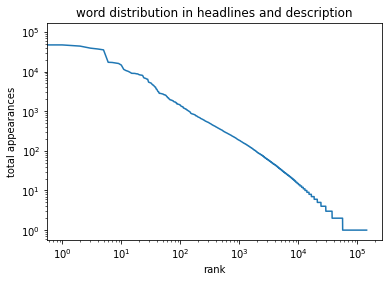

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocab_count[w] for w in vocab]);
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.title('word distribution in headlines and description')
plt.xlabel('rank')
plt.ylabel('total appearances');

In [10]:
empty = 0
eos = 1
start_idx = eos+1

In [21]:
def get_idx(vocab, vocab_count):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in iter(word2idx.items()))

    return word2idx, idx2word

In [22]:
word2idx, idx2word = get_idx(vocab, vocab_count)

In [23]:
for i in word2idx:
    if word2idx[i] not in idx2word:
        print(i, word2idx[i])

In [24]:
# read GloVe
glove_name = 'glove.6B.100d.txt'
glove_n_symbols = 400000

In [25]:
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, 100))
global_scale = 0.1

with open(glove_name, 'r') as f:
    i = 0
    for line in f:
        line = line.strip().split()
        w = line[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i, :] = list(map(float, line[1:]))
        i += 1

In [26]:
glove_embedding_weights *= global_scale

In [27]:
glove_embedding_weights.std()

0.04081572760019029

In [28]:
for w, i in iter(glove_index_dict.items()):
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

In [29]:
# embedding matrix
# generate random embedding with same scale as glove

np.random.seed(420)
shape = (40000, 100)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

In [30]:
import re

c = 0
for i in range(40000):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None:
        w = re.sub(r'[^\w\s]', '', w)
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c += 1
print('found %d tokens' % c)

found 36448 tokens


In [31]:
glove_thold = 0.5

word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    else:
        w = re.sub(r'[^\w\s]', '', w)
        if w in glove_index_dict:
            g = w
        else:
            continue
    word2glove[w] = g

In [32]:
vocab_size = 40000
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]
nb_unknown_words = 100

glove_match = []
for w,idx in iter(word2idx.items()):
    if w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thold:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print("found", len(glove_match), "subs")

found 38702 subs


In [33]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig, '=>', idx2word[sub])

0.5004291434785999 snowflakes => balloons
0.5003888562363068 Baloo => Calla
0.500344059655436 stonewalled => shooed
0.5003257062776547 stag => witch
0.5003251390235002 deplaned => frisked
0.5002325328167018 Gramenet => RGV
0.5002269090627275 varsities => counter-terror
0.5001958789135422 CTF => STF
0.5001462362300133 Rigby => JuD
0.5001229923163094 AIT => Azmi


In [34]:
glove_idx2idx = dict((word2idx[w], embedding_idx) for w, embedding_idx, _ in glove_match)

In [35]:
# data vis
Y = list()
for summ in summs:
    y = list()
    for token in summ.split():
        if len(token) < 3:
            continue
        if token in word2idx:
            y.append(word2idx[token])
        elif token.lower() in word2idx:
            y.append(word2idx[token.lower()])
        elif re.sub(r'[^\w\s]', '', token) in word2idx:
            print(token)
            y.append(re.sub(r'[^\w\s]', '', token))
    Y.append(y)
len(Y)

gram.
down".
itself."
like."
TRP.
choice".
backs."
ends."
Kriti.
?5,000.
You'.
politics."
them?"
fan".
unstoppable".
venues.
accountability.
Marshal.
beforehand.
absurd".
only".
freedom."
rule."
rights".
pensions.
ammunitions.
coming?"
films?"
excited."
palate."
warned."
sportspersons.
Jones.
53%.
Sidhwani.
?serious?.
relay.
robbery.
Goa."
licence".
Colbert.
'Heropanti'.
bhai."
Anju.
(TOI).
roll."
Medal."
offender.
(NDTV).
131.
girl?"
derogatory.
existence".
bogus.
won."
knotted.
talk".
consumption".
make?"
legal."
SL.
Mars.
activism".
forgotten."
pan.
1959.
1959.
breaststroke.
world".
fun."
[Azaan]."
biscuits.
Band'.
activities."
Pakistan's.
advantage."
Pandith.
Brexit.
riders.
Mithali.
seconds".
businessmen.
'impractical'.
appreciation.
looking."
tougher.
Badush.
Shweta.
action".
use'.
figure".
ISIS."
directed.
followed."
Elizabeth.
lab.
FBI".
okay".
Jayegi'.
Koimoi).
through".
members".
(HT).
debt.
temples".
Obamacare.
inappropriately?"
Nicholls.
Clothier.
wrongdoing.
visa."
subscri

4396

(array([  1.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   4.,   0.,   7.,
          0.,  22.,   0.,  28.,   0.,  53.,   0.,  89.,   0., 133.,   0.,
        201.,   0., 287.,   0., 384.,   0., 450.,   0., 539.,   0., 575.,
          0., 524.,   0., 431.,   0., 313.,   0., 181.,   0., 110.,   0.,
         39.,   0.,  21.,   0.,   0.,   2.]),
 array([33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
        38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
        44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
        49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
        55. , 55.5, 56. , 56.5, 57. , 57.5, 58. ]),
 <BarContainer object of 50 artists>)

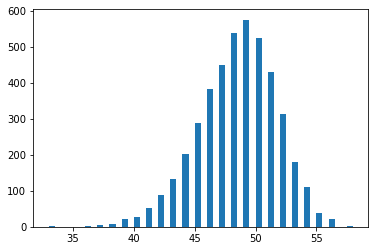

In [36]:
plt.hist(list(map(len, Y)), bins=50)

In [37]:
# data vis
X = list()
c = 0
for text in texts:
    x = list()
    for token in text.split():
        if len(token) < 3:
            continue
        if token in word2idx:
            x.append(word2idx[token])
        elif token.lower() in word2idx:
            x.append(word2idx[token.lower()])
        elif re.sub(r'[^\w\s]', '', token) in word2idx:
            print(token)
            x.append(re.sub(r'[^\w\s]', '', token))
    X.append(x)
len(X)

Microsoft?s
Kadipur,
Jind,
wash:
centres:
Priyadarshan,
Colombo,
Coimbatore,
Berlin/


4396

(array([1.674e+03, 1.955e+03, 5.340e+02, 1.290e+02, 3.700e+01, 1.800e+01,
        8.000e+00, 1.100e+01, 6.000e+00, 3.000e+00, 6.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.0000e+00, 1.9420e+02, 3.8740e+02, 5.8060e+02, 7.7380e+02,
        9.6700e+02, 1.1602e+03, 1.3534e+03, 1.5466e+03, 1.7398e+03,
        1.9330e+03, 2.1262e+03, 2.3194e+03, 2.5126e+03, 2.7058e+03,
        2.8990e+03, 3.0922e+03, 3.2854e+03, 3.4786e+03, 3.6718e+03,
        3.8650e+03, 4.0582e+03, 4.2514e+03, 4.4446e+03, 4.6378e+03,
        4.8310e+03, 5.0242e+03, 5.21

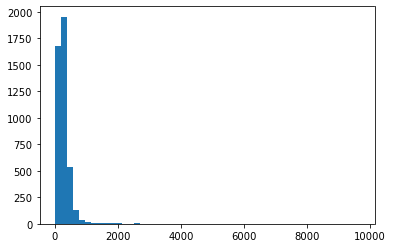

In [38]:
plt.hist(list(map(len, X)), bins=50)

In [39]:
with open('data/vocab_embed.pkl', 'wb') as f:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),f,-1)

In [40]:
with open('data/vocab_embed.data.pkl','wb') as f:
    pickle.dump((X,Y),f,-1)

In [41]:
len(X)

4396

In [42]:
len(Y)

4396

### 

In [43]:
len(idx2word)-vocab_size-len(glove_idx2idx)

64913

In [44]:
len(idx2word)

143615

In [45]:
vocab_size

40000

In [47]:
len(glove_idx2idx)

38702

In [48]:
def pprint(label, x):
    print(label + ":", ' '.join([idx2word[w] for w in x]))

In [49]:
pprint('a', Y[30])

a: Jammu and Kashmir Police have approached the Pakistan High Commission asking them claim the body Lashkar-e-Taiba commander Abu Dujana, who was killed security forces Tuesday. Notably, this the first time the authorities have approached the High Commission asking them claim the body any Pakistani national killed anti-militancy operation the state.
